In [15]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [16]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="RH-Temp")
dataFrame = dataFrame.tail(1000)

In [17]:
dataFrame = dataFrame.interpolate(method='linear')

In [18]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [19]:
# dataFrame[['RH']].plot(figsize= (20,4))
# dataFrame[['Temp']].plot(figsize= (20,4))

In [20]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")


In [21]:
stationary(dataFrame[['RH']], 'RH')
stationary(dataFrame[['Temp']], 'Temp')
stationary(dataFrame.RH.diff().dropna(), 'RH_diff')
stationary(dataFrame.Temp.diff().dropna(), 'Temp_diff')

'RH' is stationary: False.
'Temp' is stationary: True.
'RH_diff' is stationary: True.
'Temp_diff' is stationary: True.


In [22]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrame = trainSet
dataFrame = dataFrame.diff().dropna()

In [23]:
from statsmodels.tsa.api import VAR
model = VAR(dataFrame)

In [24]:
sorted_order = model.select_order(60)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.958       4.969       142.4       4.962
1        4.373       4.405       79.31       4.386
2        4.214       4.267       67.64       4.234
3        4.140       4.215       62.81       4.169
4        4.110       4.205       60.92       4.146
5        4.090       4.207       59.74       4.135
6        4.061      4.199*       58.02       4.114
7        4.053       4.213       57.57       4.114
8        4.029       4.210       56.21       4.098
9        4.009       4.211       55.08       4.086
10       3.995       4.218       54.32       4.080
11       3.981       4.225       53.55       4.074
12       3.966       4.232       52.78       4.068
13       3.949       4.236       51.88       4.059
14       3.949       4.257       51.86       4.066
15       3.924       4.254       50.62       4.050
16       3.915       4.267     

In [25]:
lag = sorted_order.aic
results = model.fit(lag)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Mar, 2023
Time:                     00:23:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.27299
Nobs:                     943.000    HQIC:                   4.01205
Log likelihood:          -4410.02    FPE:                    47.0611
AIC:                      3.85134    Det(Omega_mle):         43.2210
--------------------------------------------------------------------
Results for equation RH
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.037364         0.087640           -0.426           0.670
L1.RH            0.559646         0.033114           16.900           0.000
L1.Temp          0.013990         0.036501            0.383           0.702
L2.RH  

In [26]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
idx = pd.Index(dateTimeIndex, name='time')
predictions = results.forecast(dataFrame.values[-lag :], steps = step)
dataFramePredicted = pd.DataFrame(predictions, index=idx, columns=dataFrame.columns.values)
dataFramePredicted =  trainSet.iloc[-1] + dataFramePredicted.cumsum(axis=0)

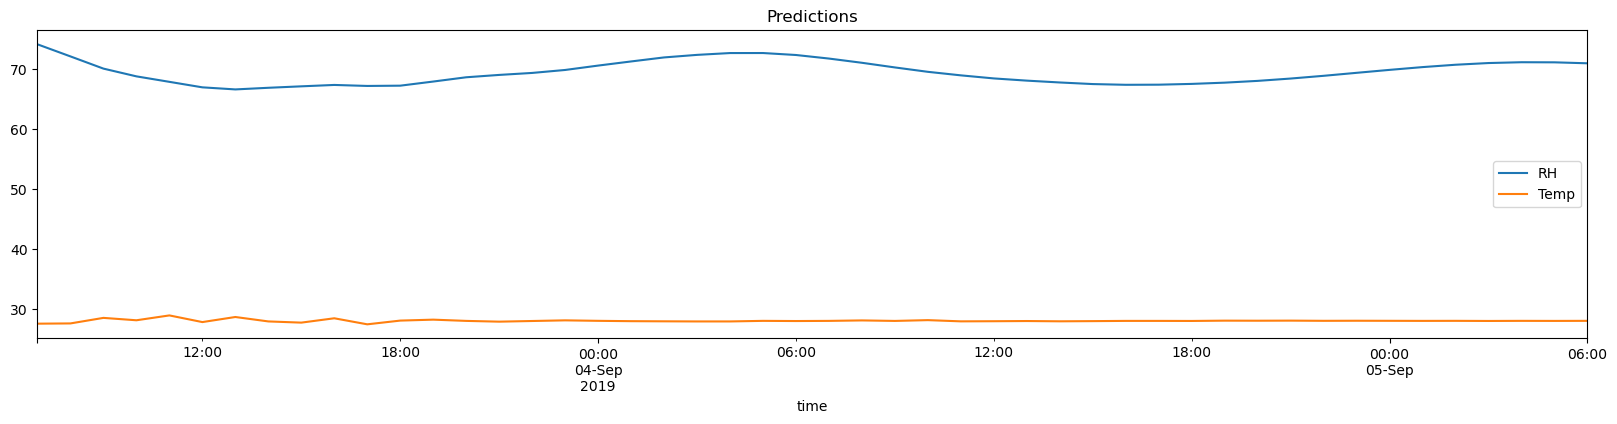

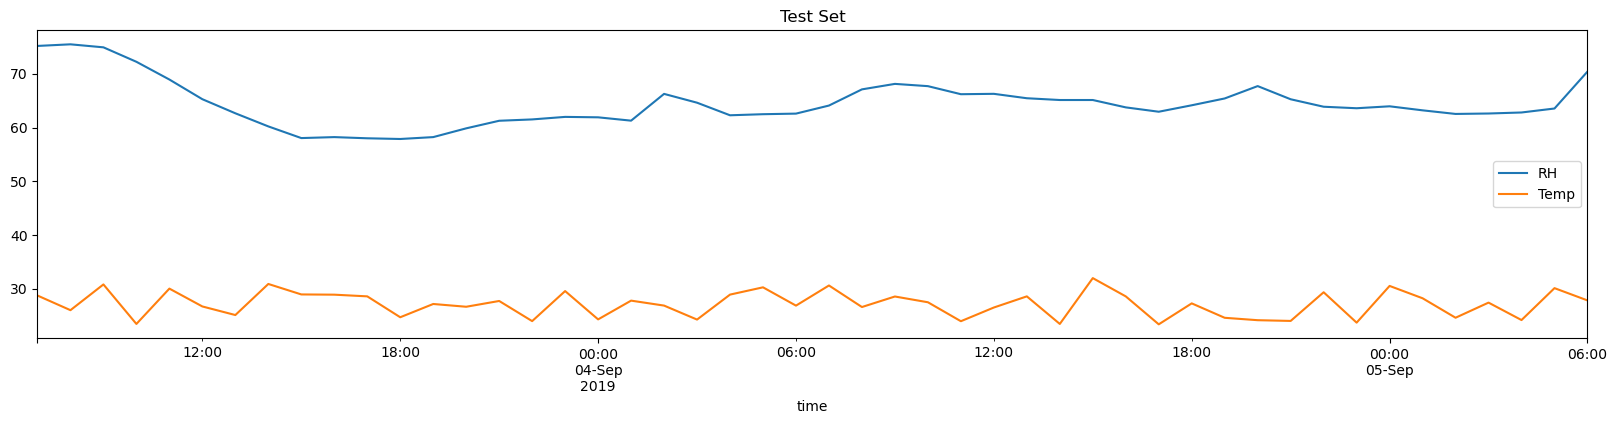

In [27]:
predictRHFig = dataFramePredicted.plot(figsize=(20,4), title='Predictions')
testFig = testSet.plot(figsize=(20,4), title='Test Set')
figure = predictRHFig.get_figure()    
figure.savefig(f'../figure/predictRHFig.png',bbox_inches ="tight")
figure = testFig.get_figure()    
figure.savefig(f'../figure/testRHFig.png',bbox_inches ="tight")

In [28]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
metric = pd.DataFrame(tmp,index=dataFramePredicted.columns.values)
print(metric)

          mape        me       mae       mpe      rmse      corr    minmax
RH    0.090463  5.101113  5.662587  0.082866  6.440799  0.349190  0.081040
Temp  0.081536  0.896912  2.113499  0.041224  2.563114  0.065092  0.073791


C:\Users\admin\AppData\Local\Temp\ipykernel_12444\557993791.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_12444\557993791.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_12444\557993791.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_12444\557993791.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:,